# A/B Testing

## Table of Contents
- [Background](#background)
- [Dataset](#dataset)
- [Import Necessary Libraries](#import-necessary-libraries)
- [Data Import](#data-import)
- [Statistical Summary](#stats_sum)
- [Outliers](#outliers)
- [Insights](#insights)
- [A/B Testing](#ab_testing)
- [Conclusion](#conclusion)


## Background <a class="anchor" id="background"></a>

Cookie Cats is a hugely popular mobile puzzle game developed by Tactile Entertainment. It's a classic "connect three" style puzzle game where the player must connect tiles of the same color in order to clear the board and win the level.

As players progress through the game they will encounter gates that force them to wait some time before they can progress or make an in-app purchase. In this project, we will analyze the result of an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40. In particular, we will analyze the impact on player retention and game rounds.

## Dataset <a class="anchor" id="dataset"></a>

The data is from 90,189 players that installed the game while the AB-test was running. The variables are:

- `userid` - a unique number that identifies each player.
- `version` - whether the player was put in the control group (gate_30 - a gate at level 30) or the test group (gate_40 - a gate at level 40).
- `sum_gamerounds` - the number of game rounds played by the player during the first week after installation
- `retention_1` - did the player come back and play 1 day after installing?
- `retention_7` - did the player come back and play 7 days after installing?

When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40.

## Import Necessary Libraries <a class="anchor" id="import-necessary-libraries"></a>

In [11]:
# Base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Hypothesis testing
from scipy.stats import shapiro
import scipy.stats as stats

# Config
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format

sns.set_style('darkgrid')

## Data Import <a class="anchor" id="data-import"></a>

In [2]:
df = pd.read_csv('./data/cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [3]:
# Null values
df.isnull().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

In [4]:
# Dataset size
df.shape

(90189, 5)

## Statistical Summary <a class="anchor" id="stats_sum"></a>

In [8]:
# Summary stats: sum_gamerounds
df.describe([0.01,0.05,0.10,0.20,0.80,0.90,0.95,0.99])[['sum_gamerounds']].T

,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
sum_gamerounds,90189.0000,51.8725,195.0509,0.0000,0.0000,1.0000,1.0000,3.0000,16.0000,67.0000,134.0000,221.0000,493.0000,49854.0000


In [9]:
# A/B groups and summary stats
df.groupby('version').sum_gamerounds.agg(['count','median','mean','std','max'])

,count,median,mean,std,max
version,,,,,
gate_30,44700,17.0000,52.4563,256.7164,49854
gate_40,45489,16.0000,51.2988,103.2944,2640


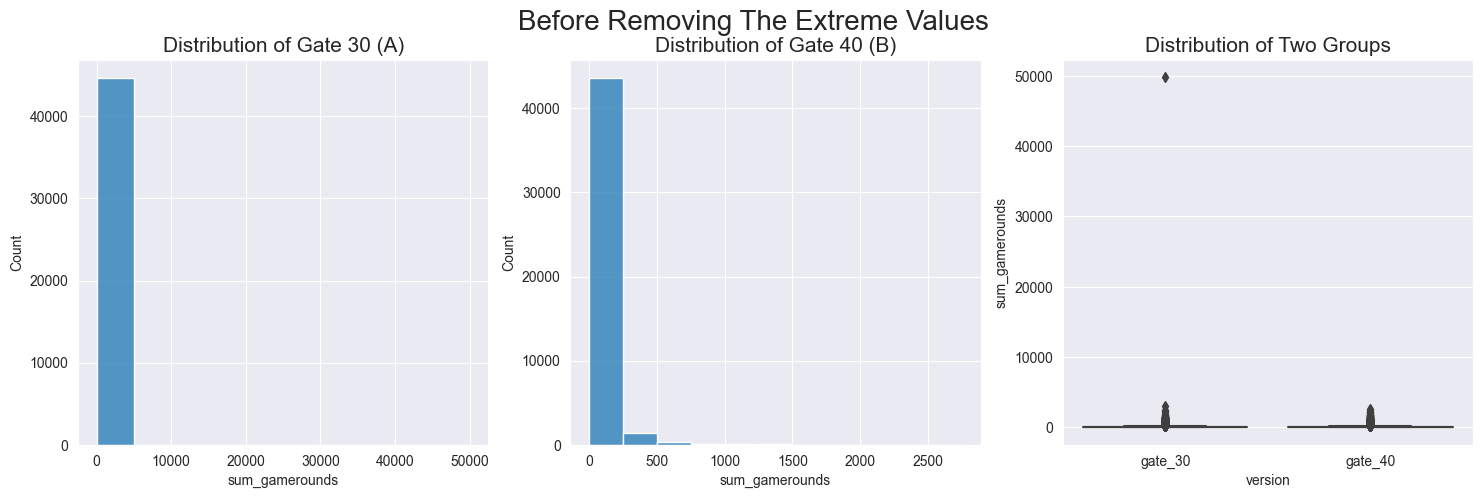

In [18]:
fig, axes = plt.subplots(1,3,figsize=(18,5))
plt.suptitle('Before Removing The Extreme Values', fontsize=20)

# Group A histogram
sns.histplot(data=df[df.version == 'gate_30'], x='sum_gamerounds', binwidth=5000,ax=axes[0])
axes[0].set_title('Distribution of Gate 30 (A)', fontsize=15)

# Group B histogram
sns.histplot(data=df[df.version == 'gate_40'], x='sum_gamerounds', binwidth=250,ax=axes[1])
axes[1].set_title('Distribution of Gate 40 (B)', fontsize=15)

# Both groups' box plot
sns.boxplot(data=df, x='version', y='sum_gamerounds', ax=axes[2])
axes[2].set_title('Distribution of Two Groups', fontsize=15)

plt.show()

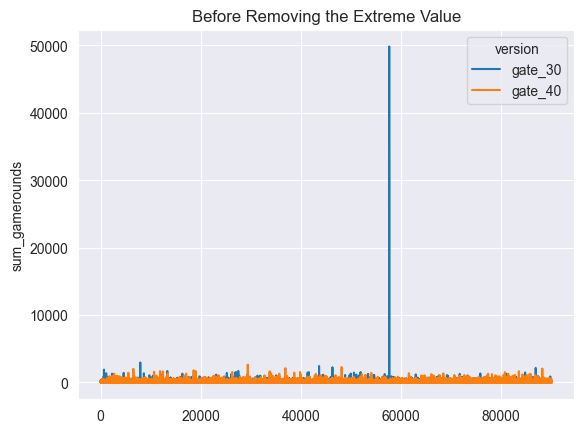

In [35]:
sns.lineplot(data=df, x=df.index,y='sum_gamerounds', hue='version')
plt.title('Before Removing the Extreme Value')
plt.show()

## Outliers <a class="anchor" id="outliers"></a>

In [36]:
df = df[df.sum_gamerounds < df.sum_gamerounds.max()]

# Summary stats: sum_gamerounds
df.describe([0.01,0.05,0.10,0.20,0.80,0.90,0.95,0.99])[['sum_gamerounds']].T


,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
sum_gamerounds,90188.0000,51.3203,102.6827,0.0000,0.0000,1.0000,1.0000,3.0000,16.0000,67.0000,134.0000,221.0000,493.0000,2961.0000


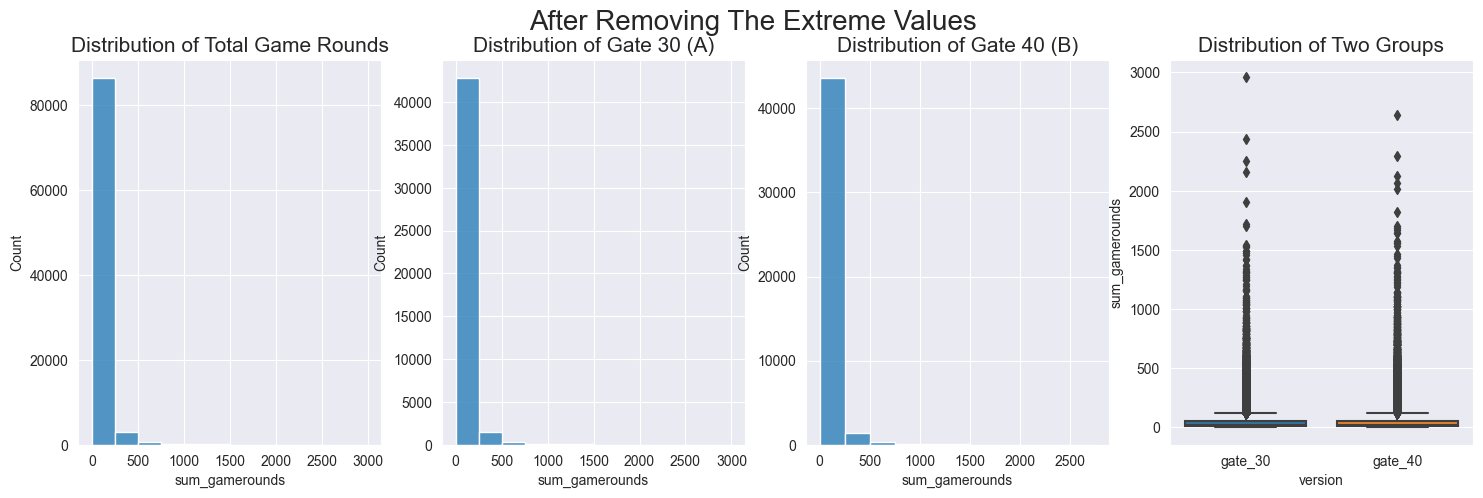

In [37]:
fig, axes = plt.subplots(1,4,figsize=(18,5))
plt.suptitle('After Removing The Extreme Values', fontsize=20)

# Both groups' histogram
sns.histplot(data=df, x='sum_gamerounds', binwidth=250, ax=axes[0])
axes[0].set_title('Distribution of Total Game Rounds', fontsize=15)

# Group A histogram
sns.histplot(data=df[df.version == 'gate_30'], x='sum_gamerounds', binwidth=250,ax=axes[1])
axes[1].set_title('Distribution of Gate 30 (A)', fontsize=15)

# Group B histogram
sns.histplot(data=df[df.version == 'gate_40'], x='sum_gamerounds', binwidth=250,ax=axes[2])
axes[2].set_title('Distribution of Gate 40 (B)', fontsize=15)

# Both groups' box plot
sns.boxplot(data=df, x='version', y='sum_gamerounds', ax=axes[3])
axes[3].set_title('Distribution of Two Groups', fontsize=15)

plt.show()

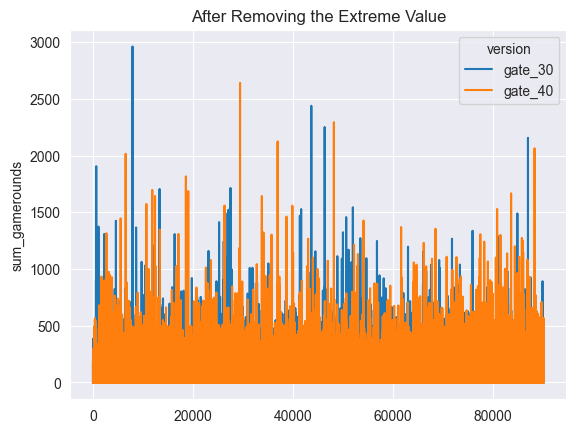

In [38]:
sns.lineplot(data=df, x=df.index,y='sum_gamerounds', hue='version')
plt.title('After Removing the Extreme Value')
plt.show()

## Insights <a class="anchor" id="insights"></a>

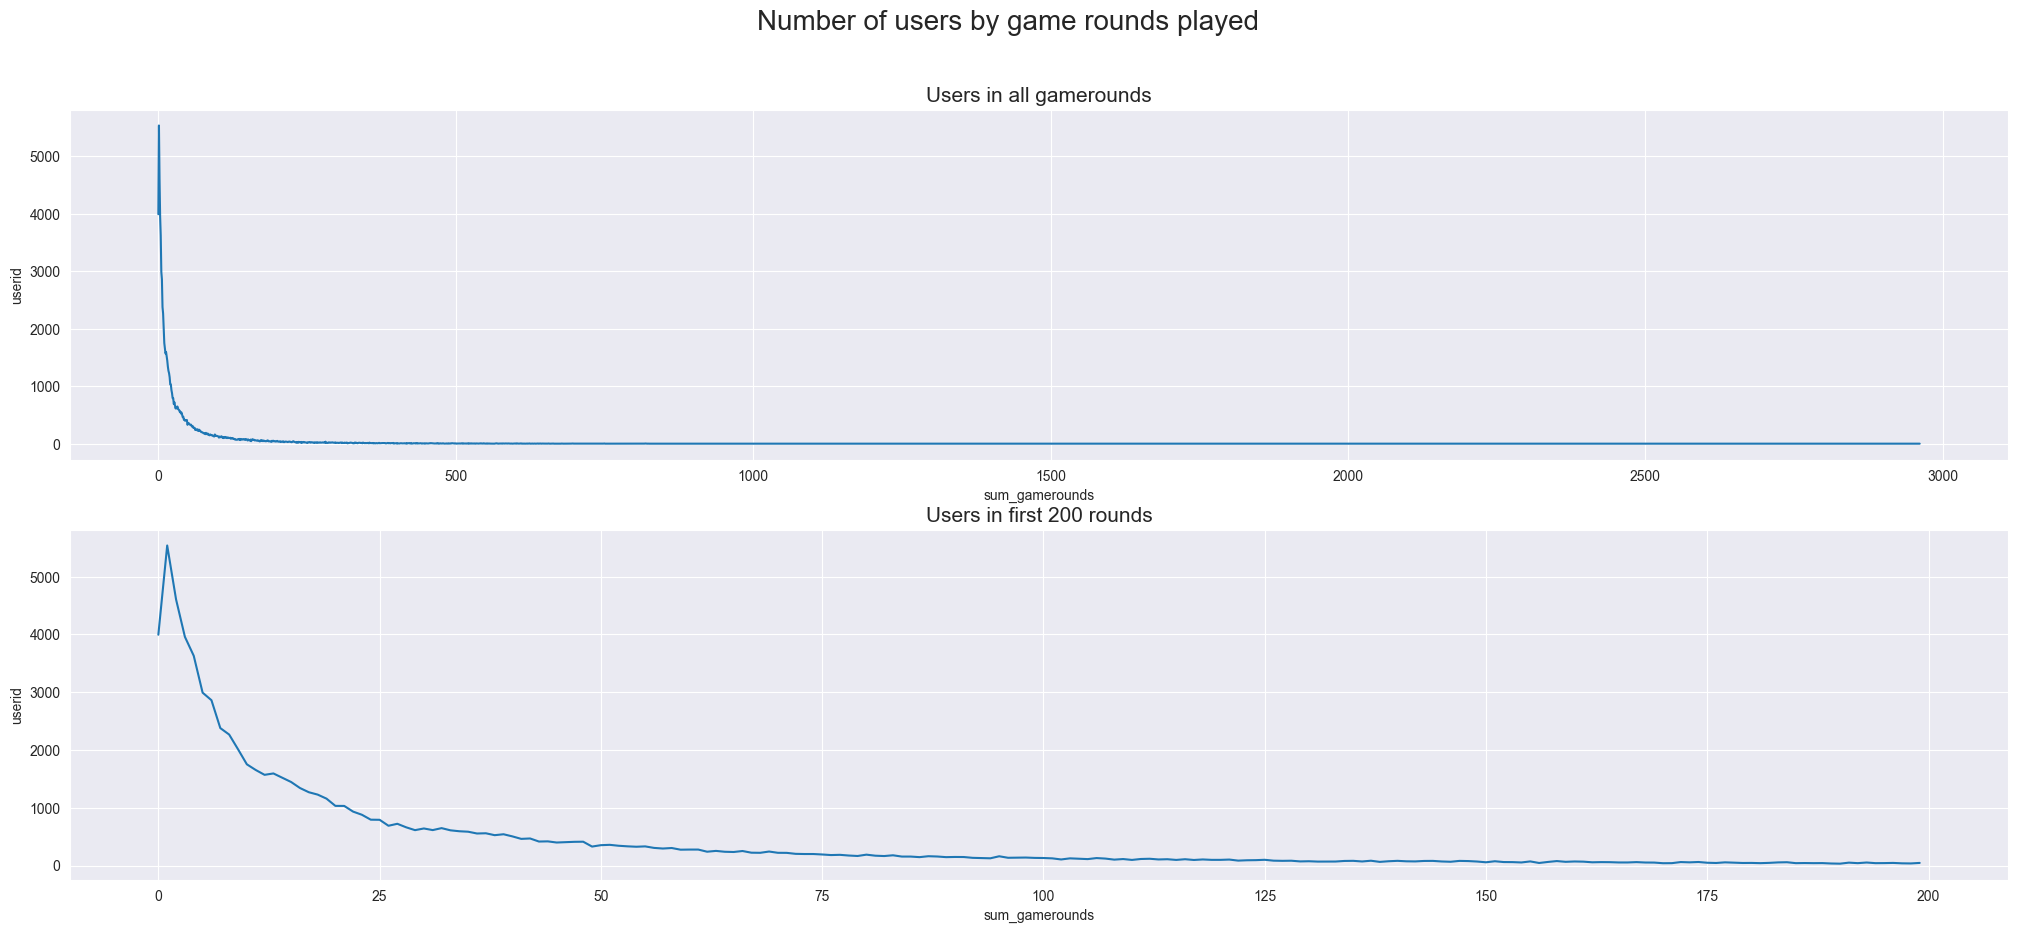

In [43]:
fig, axes = plt.subplots(2, 1, figsize = (25,10))
plt.suptitle('Number of users by game rounds played', fontsize=20)

# All rounds
sns.lineplot(data=df.groupby('sum_gamerounds')[['userid']].count(), x='sum_gamerounds',y='userid',ax=axes[0])
axes[0].set_title('Users in all gamerounds', fontsize=15)

# First 200 rounds
sns.lineplot(data=df.groupby('sum_gamerounds')[['userid']].count()[:200], x='sum_gamerounds',y='userid',ax=axes[1])
axes[1].set_title('Users in first 200 rounds', fontsize=15)

plt.show()

In [44]:
df.groupby('sum_gamerounds')[['userid']].count().head(20)

,userid
sum_gamerounds,
0,3994
1,5538
2,4606
3,3958
4,3629
5,2992
6,2861
7,2379
8,2267


**The game was installed but never played by 3994 users!** Some of the reasons may be:
- Users have no time to play the game.
- Users prefer other games over this game.
- User experience of the game is not good.

**The number of users decrease as the rounds progress.**
- Most users did not progress
- Difficulty of the game increases as rounds progress
- Gifts or rewards may help with player retention
- More data and research required to understand the high churn rate.

In [45]:
# How many users reached gate 30 and gate 40 level
df.groupby('sum_gamerounds')[['userid']].count().loc[[30,40]]

,userid
sum_gamerounds,
30,642
40,505


In [46]:
# A/B Groups and Target Summary Stats
df.groupby('version').sum_gamerounds.agg(['count','median','mean','std','max'])

,count,median,mean,std,max
version,,,,,
gate_30,44699,17.0000,51.3421,102.0576,2961
gate_40,45489,16.0000,51.2988,103.2944,2640


From the above summary, both groups seem similar. However, to check whether the differences between the groups are statistically significant, A/B testing has to be conducted.

In [47]:
# Retention
pd.DataFrame({"RET1_COUNT": df["retention_1"].value_counts(),
              "RET7_COUNT": df["retention_7"].value_counts(),
              "RET1_RATIO": df["retention_1"].value_counts() / len(df),
              "RET7_RATIO": df["retention_7"].value_counts() / len(df)})

,RET1_COUNT,RET7_COUNT,RET1_RATIO,RET7_RATIO
False,50035,73408,0.5548,0.8139
True,40153,16780,0.4452,0.1861


It can be inferred from retention summary statistics that:
- 55% of the players did not play the game 1 day after installing.
- 81% of the players did not play the game 7 days after installing.

In [48]:
df.groupby(['version','retention_1']).sum_gamerounds.agg(['count','median','mean','std','max'])

count  median    mean      std   max
version retention_1                                      
gate_30 False        24665  6.0000 16.3591  36.5284  1072
        True         20034 48.0000 94.4117 135.0377  2961
gate_40 False        25370  6.0000 16.3404  35.9258  1241
        True         20119 49.0000 95.3812 137.8873  2640

In [49]:
df.groupby(['version','retention_7']).sum_gamerounds.agg(['count','median','mean','std','max'])

count   median     mean      std   max
version retention_7                                        
gate_30 False        36198  11.0000  25.7965  43.3162   981
        True          8501 105.0000 160.1175 179.3586  2961
gate_40 False        37210  11.0000  25.8564  44.4061  2640
        True          8279 111.0000 165.6498 183.7925  2294

The statitical summary indicates that there are similarities between the groups.

In [50]:
df['Retention'] = np.where((df.retention_1 == True) & (df.retention_7 == True),1,0)
df.groupby(['version','Retention']).sum_gamerounds.agg(['count','median','mean','std','max'])

count   median     mean      std   max
version Retention                                        
gate_30 0          38023  12.0000  28.0703  48.0175  1072
        1           6676 127.0000 183.8863 189.6264  2961
gate_40 0          38983  12.0000  28.1034  48.9278  2640
        1           6506 133.0000 190.2824 194.2201  2294

Similar results are seen when comparing the number of users who played or did not play the game after both 1 day and 7 days of installing. Approximately 12,000 users (6676+6506) played the game both 1 day and 7 days after installing. Hence, 14% of the users who install the game, continue to play it in the future.

In [51]:
df['Combined_Retention'] = list(map(lambda x,y: str(x)+'-'+str(y), df.retention_1, df.retention_7))
df.groupby(['version','Combined_Retention']).sum_gamerounds.agg(['count','median','mean','std','max'])

count   median     mean      std   max
version Combined_Retention                                        
gate_30 False-False         22840   6.0000  11.8197  21.6426   981
        False-True           1825  43.0000  73.1693  93.2223  1072
        True-False          13358  33.0000  49.6945  58.1254   918
        True-True            6676 127.0000 183.8863 189.6264  2961
gate_40 False-False         23597   6.0000  11.9133  20.9010   547
        False-True           1773  47.0000  75.2611  94.4780  1241
        True-False          13613  32.0000  50.0255  60.9246  2640
        True-True            6506 133.0000 190.2824 194.2201  2294

When comparing combined retention of the groups, the results are similar too.

## A/B Testing <a class="anchor" id="ab_testing"></a>

<img src="AB Test Flow Chart.png">

**Steps**:
- Check normality using Shapiro test
- If normal distribution (parametric), check homogeneity of variances using Levene test
- If Parametric + Homogeneous, apply T-test for equal variances
- If Parametric - Homogeneous, apply T-test for unequal variances (Welch's T-test)
- If non-parametric, apply Mann-Whitney _U_ test

In [52]:
# Define A/B groups
df['version'] = np.where(df.version == 'gate_30', 'A', 'B')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7,Retention,Combined_Retention
0,116,A,3,False,False,0,False-False
1,337,A,38,True,False,0,True-False
2,377,B,165,True,False,0,True-False
3,483,B,1,False,False,0,False-False
4,488,B,179,True,True,1,True-True


In [54]:
# A/B Testing Function
def AB_Test(data, group, target):
    
    # A/B split
    groupA = data[data[group] == 'A'][target]
    groupB = data[data[group] == 'B'][target]
    
    #Checking normality
    ntA = shapiro(groupA)[1] > 0.05
    ntB = shapiro(groupB)[1] > 0.05
    # H0: Distribution is normal - True
    # H1: Distribution is not normal - False
    
    if ntA and ntB:
        #Parametric test
        test_type = 'Parametric'
        #Check homogeneity of variances
        leveneTest = stats.levene(groupA,groupB)[1] > 0.05
        # H0: Homogeneity - True
        # H1: Hetereogeneity - False
        
        if leveneTest:
            # Homogeneity
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1] 
            # H0: M1 == M2 - True
            # H1: M1 != M2 - False
        else:
            # Heterogeneity
            ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
            # H0: M1 == M2 - True
            # H1: M1 != M2 - False
    else:
        # Non-parametric test
        test_type = 'Non-parametric'
        ttest = stats.mannwhitneyu(groupA,groupB)[1]
        # H0: M1 == M2 - True
        # H1: M1 != M2 - False
        
    # Result
    temp = pd.DataFrame({'AB Hypothesis':[ttest>0.05],
                         'p-value':[ttest]})
    temp['Test Type'] = test_type
    temp['AB Hypothesis'] = np.where(temp['AB Hypothesis'], 'Fail to reject H0','Reject H0')
    temp['Comment'] = np.where(temp['AB Hypothesis'] == 'Reject H0','A/B groups are not similar','A/B groups are similar')
    
    if test_type == 'Parametric':
        temp['Homogeneity'] = np.where(leveneTest, 'Yes','No')
        temp = temp[['Test Type','Homogeneity','AB Hypothesis','p-value','Comment']]
    else:
        temp = temp[['Test Type','AB Hypothesis','p-value','Comment']]    
    
    # Print Hypothesis
    print('A/B Testing hypotheses')
    print('H0: A == B')
    print('H1: A != B')
    
    return temp

# Apply A/B Testing
AB_Test(data=df, group='version', target='sum_gamerounds')

A/B Testing hypotheses
H0: A == B
H1: A != B


,Test Type,AB Hypothesis,p-value,Comment
0,Non-parametric,Fail to reject H0,0.0509,A/B groups are similar


## Conclusion <a class="anchor" id="conclusion"></a>

Firstly, the relationships and structures in the data was investigated. No missing values were present, however, there was one outlier in the data. Statistical summary and plots facilitated in understanding the data and the problem.

Before A/B Testing, some insights were shared regarding the game and users along with suggestions to the stakeholders.

A/B Testing revealed important statistical information about the data. Shapiro testing rejected the null the hypothesis of normal data distribution. Hence, a non-parametric test, called Mann-Whitney _U_ test, was used to compare the groups. As a result, the non-parametric test failed to reject the null hypothesis implying A/B groups are similar.

In conclusion, there is no statitically significant difference between the two groups where first gate is at level 30 or where the first gate is at level 40 in the game.

**Which version is better in terms of player retention?**

In [55]:
df.groupby('version').retention_1.mean(), df.groupby('version').retention_7.mean()

(version
 A   0.4482
 B   0.4423
 Name: retention_1, dtype: float64,
 version
 A   0.1902
 B   0.1820
 Name: retention_7, dtype: float64)

On average, version A (gate at level 30) has better retention after day 1 and day 7. Given the result of A/B testing, we can conclude that either version A is better or more data is required for further analysis.